# Mapping and Perception for an autonomous robot (0510-7951)

### 2024/B

### Written by Roy Orfaig


#### Visual Odomtery

Visual odometry is the process of determining odometry information using sequential camera images to estimate the distance traveled. It allows for enhanced navigational accuracy in robots or vehicles using any type of locomotion on any surface. In this session, we will download a sequence of images from a real recording and implement the entire pipeline to get the location of a car based solely on camera data. We will use the ground truth distance at each step to simulate an odometer.

-------------------------------------

**Instructions**

1. Go to [**KITTI dataset**](http://www.cvlibs.net/datasets/kitti/) ,and download your specific records from odomtery session (see below what to download).
2. Select trajectory number 02 from the scenarios.
3. Fill in the code the "TODO" section
4. Answer the question inside the sections
5. **Please copy all the results to the report:**
  - Outputs- Images, tables, scores,etc
  - Performace, analysis and your explanations.
  - Attach the completed notebook to the report package.

Good luck!

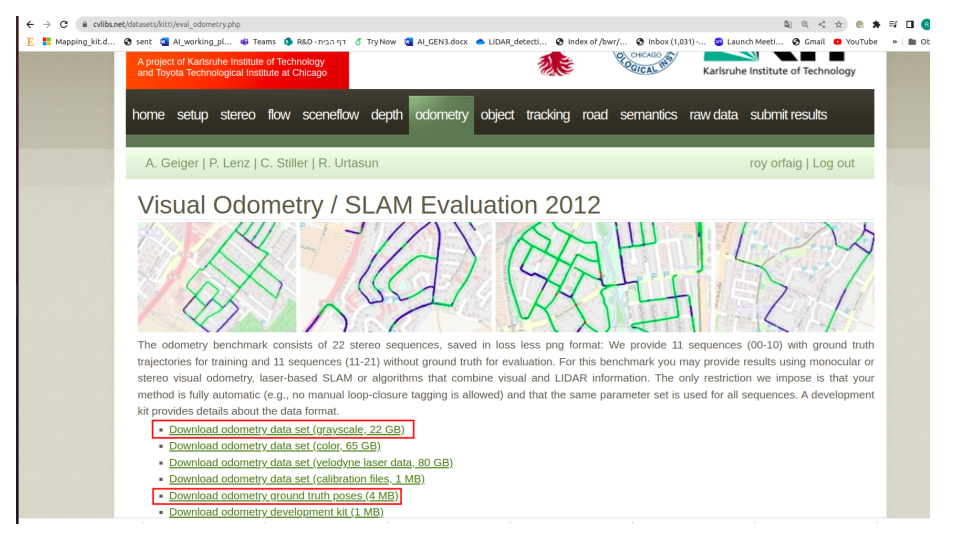

In [ ]:
#Name of student: Nadav Marciano
#ID:  305165698

import os
from visual_odometry import VisualOdometry
from data_loader import DataLoader

In [1]:
import sys
project_path = r"C:\Users\Nadav\Desktop\TAU\מיפוי וחישה למערכות אוטונמיות\Project_4\VO"
sys.path.append(project_path)

In [59]:
import os
import numpy as np
import cv2
import os
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from tqdm import tqdm
from data_loader import DataLoader
from camera import Camera



class VisualOdometry:
    def __init__(self, vo_data,N):
        """
        Initialize the VO class with the loaded data vo_data
        lastly, initialize the neutral rotation and translation matrices
        """
        self.vo_data = vo_data
        self.N=N
        # initial camera pose
        self.camera_rotation = np.eye(3) #TODO hint- initial matrix, diagonal 1
        self.camera_translation = np.array([0, 0, 0]) #TODO hint- initial vector, zero
        self.outputdir = vo_data.output

    def calc_trajectory(self):
        """
        apply the visual odometry algorithm
        """
        self.camera_translation = self.camera_translation.astype(np.float64)
        gt_trajectory = np.array([]).reshape(0, 2)
        measured_trajectory = np.array([]).reshape(0, 2)
        xz_error_arr = np.array([0.0],dtype='float32')
        prev_img = None
        prev_gt_pose = None
        i = 0
        frame_lst = []
        for curr_img, curr_gt_pose in tqdm(zip(self.vo_data.images, self.vo_data.gt_poses)):
            
            if prev_img is None:
                prev_img = curr_img
                prev_gt_pose = curr_gt_pose
                prev_c = np.eye(4)
                continue
                
            # Break the loop after processing frame N
            if i >= self.N:
                break

            ## extract features for prev and current image
            #TODO (hint- use SIFT)
            #TODO (prev frame)
            #TODO (current frame)
            sift = cv2.SIFT_create()
            prev_keypoints, prev_descriptors = sift.detectAndCompute(prev_img, None)
            curr_keypoints, curr_descriptors = sift.detectAndCompute(curr_img, None)

               
            ## match the point (hint- use BFMatcher)
            #TODO
            bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
            matches = bf.match(prev_descriptors, curr_descriptors)
            matches = sorted(matches, key=lambda x: x.distance)
            
            # Convert keypoints to numpy arrays for the matched points
            prev_points = np.float32([prev_keypoints[m.queryIdx].pt for m in matches]).reshape(-1, 2)
            curr_points = np.float32([curr_keypoints[m.trainIdx].pt for m in matches]).reshape(-1, 2)           

            ## etimate E or F matrix 
            E, mask = cv2.findEssentialMat(curr_points, prev_points, self.vo_data.cam.intrinsics, method=cv2.RANSAC, prob=0.999, threshold=1.0)
           
             ## find current rotation and translation (hint- use recorePose)
            _, R, t, mask = cv2.recoverPose(E, curr_points, prev_points, self.vo_data.cam.intrinsics)
            
            
            # calculate the scale
            scale = np.divide(np.linalg.norm(curr_gt_pose[:, 3]-prev_gt_pose[:, 3]),
                             np.linalg.norm(np.squeeze(t)))
            
            # calculate camera_translation using the scale

            self.camera_translation += scale * self.camera_rotation @ np.squeeze(t) # TODO
            
            # calculate camera rotation
            self.camera_rotation = R @ self.camera_rotation

            ## calc groundTruth
            gt_trajectory = np.concatenate((gt_trajectory, np.array([[curr_gt_pose[0, 3], curr_gt_pose[2, 3]]])),
                                           axis=0)  # groundTruth
            measured_trajectory = np.concatenate((measured_trajectory, np.array(
                [[float(self.camera_translation[0]), float(self.camera_translation[2])]])), axis=0)

            ## calculate the distance error
            xz_error_arr = np.concatenate((xz_error_arr, np.array([np.linalg.norm(np.array([curr_gt_pose[0, 3], curr_gt_pose[2, 3]]) - np.array([self.camera_translation[0], self.camera_translation[2]]))])), axis=0)


            fig_image, ax_image = plt.subplots(figsize=(8, 8))
            fig_error_plot, ax_error_plot = plt.subplots(figsize=(8, 8))
            fig_trajectory, ax_trajectory = plt.subplots(figsize=(8, 8))
            res_img=self.visualization(gt_trajectory, measured_trajectory, prev_points, curr_points, xz_error_arr,
                               curr_img, ax_image, ax_error_plot, ax_trajectory, i, [i], './')
            plt.close(fig_image)
            plt.close(fig_error_plot)
            plt.close(fig_trajectory)
            output_dir=self.outputdir
            # Save the visualization image
            if i % 10 == 0:
                print("frame:",i)
                output_filename = f"{str(i).zfill(6)}_VO.png"
                output_path = os.path.join(output_dir, output_filename)
                cv2.imwrite(output_path, res_img)

            i += 1
            prev_img = curr_img
            prev_gt_pose = curr_gt_pose
       
     
        fps = 10
        if (False):
            size = frame_lst[0].shape
            out = cv2.VideoWriter(os.path.join('.', 'part3_anim.avi'),
                                  cv2.VideoWriter_fourcc(*'MJPG'), fps, (size[1], size[0]))
            for i in range(len(frame_lst)):
                out.write(frame_lst[i])
            out.release()

        return gt_trajectory, measured_trajectory

 
 
    #@Helpfull reference
    @staticmethod
    def visualization(GT_location,VO_location,prev_points,curr_points,xz_error_arr,curr_image,ax_image, ax_error_plot, ax_trajectory, frame_idx,idx_frames_for_save,dest_dir):
        """
        plot the graphes of the VO include: image, GT and estimated trajectory, features.
        :param GT_location: GT location
        :param VO_location: VO estimated location
        :param prev_points: KeyPoints from the previous frame.
        :param curr_points: match KeyPoints in the current frame of the previos frame.
        :param xz_error_arr: euclidian distance error in (x,y)
        :param curr_image: current image
        :param ax_image: Axis object for the image
        :param ax_error_plot: Axis object for the error plot
        :param ax_trajectory: Axis object for the trajectory plot
        :param frame_idx: frame index
        :param idx_frames_for_save: the indexes of the frames we want to save their graphs.
        :param dest_dir: the directory name for saving the graphs and animations to.
        :return: the frame graph.
        """
        Frame=[]
        plot_0=ax_image.imshow(curr_image,cmap='gray')
        Frame.append(plot_0)
        plot_1=ax_image.scatter(curr_points[:,0],curr_points[:,1],s=2,linewidths=0.7,edgecolors="b",marker="o")
        Frame.append(plot_1)
        plot_2=ax_image.scatter(prev_points[:, 0], prev_points[:, 1], s=2,linewidths=0.7, edgecolors="g",marker="P")
        Frame.append(plot_2)
        plot_3,=ax_trajectory.plot(VO_location[:,0],VO_location[:,1],c="r")
        Frame.append(plot_3)
        plot_4,=ax_trajectory.plot(GT_location[:, 0], GT_location[:, 1],"--b")
        Frame.append(plot_4)

        plot_5, = ax_error_plot.plot(xz_error_arr,c="orange")
        Frame.append(plot_5)
        if frame_idx == 1:
            ax_image.legend(["current key points", "Previous key points"],loc="upper right")
            ax_trajectory.legend(["VO-Estimated with scale", "GT"],loc="upper right")
            ax_trajectory.grid()
            ax_error_plot.grid()

        # if frame_idx in idx_frames_for_save:
        fig_2 = plt.figure(figsize=[16, 12])
        grid = plt.GridSpec(12, 17, hspace=0.2, wspace=0.2)
        ax_image_2 = fig_2.add_subplot(grid[:5, :], title="Scene Image,Frame: {}".format(frame_idx))
        ax_error_plot_2 = fig_2.add_subplot(grid[6:, :8], title="Euclidean Distance Error", xlabel="Frame number",ylabel="Error[m]")
        ax_trajectory_2 = fig_2.add_subplot(grid[6:, 9:], title="Trajectory", xlabel="X[m]", ylabel="Y[m]",xlim=(-50, 750), ylim=(-100, 1000))
        ax_image_2.axis('off')
        ax_image_2.imshow(curr_image, cmap='gray')
        ax_image_2.scatter(curr_points[:, 0], curr_points[:, 1], s=2, linewidths=0.5, edgecolors="b", marker="o")
        ax_image_2.scatter(prev_points[:, 0], prev_points[:, 1], s=2, linewidths=0.5, edgecolors="g", marker="P")
        ax_trajectory_2.plot(VO_location[:, 0], VO_location[:, 1], c="r")
        ax_trajectory_2.plot(GT_location[:, 0], GT_location[:, 1], "--b")
        ax_error_plot_2.plot(xz_error_arr, c="orange")
        ax_image_2.legend(["current key points", "Previous key points"], loc="upper right")
        ax_trajectory_2.legend(["VO-Estimated with scale", "GT"], loc="upper right")
        ax_trajectory_2.grid()
        ax_error_plot_2.grid()
        #plt.savefig(dest_dir + "/Visual Odometry Frame #{}".format(frame_idx))
        fig_2.canvas.draw()

        # grab the pixel buffer and dump it into a numpy array
        rgba_buf = fig_2.canvas.buffer_rgba()
        (w, h) = fig_2.canvas.get_width_height()
        rgba_arr = np.frombuffer(rgba_buf, dtype=np.uint8).reshape((h, w, 4))
        plt.close()
        bgra_arr = cv2.cvtColor(rgba_arr[:, :, :3], cv2.COLOR_RGB2BGR)
        return bgra_arr

        # return Frame

    @staticmethod
    def save_animation(ani, basedir, file_name):
        """
        save animation function
        :param ani: animation object
        :param basedir: the parent dir of the animation dir.
        :param file_name: the animation name
        :return: None
        """
        print("Saving animation")
        if not os.path.exists(basedir + "/Animation videos"):
            os.makedirs(basedir + "/Animation videos")
        gif_file_path = os.path.join(basedir + "/Animation videos", f'{file_name}.gif')
        mp4_file_path = os.path.join(basedir + "/Animation videos", f'{file_name}.mp4')

        writergif = animation.PillowWriter(fps=30)
        ani.save(gif_file_path, writer=writergif)

        # clip = mp.VideoFileClip(gif_file_path)
        # clip.write_videofile(mp4_file_path)
        os.remove(gif_file_path)
        print("Animation saved")

In [60]:
class ProjectQuestions:
    def __init__(self,vo_data,N):
        assert type(vo_data) is dict, "vo_data should be a dictionary"
        self.vo_data = vo_data
        self.N = N
    
    def run(self):
        vo_data = DataLoader(self.vo_data)
        vo = VisualOdometry(vo_data,self.N)
        gt_trajectory, measured_trajectory=vo.calc_trajectory()
        return  gt_trajectory, measured_trajectory
    

# Run visual odometry!

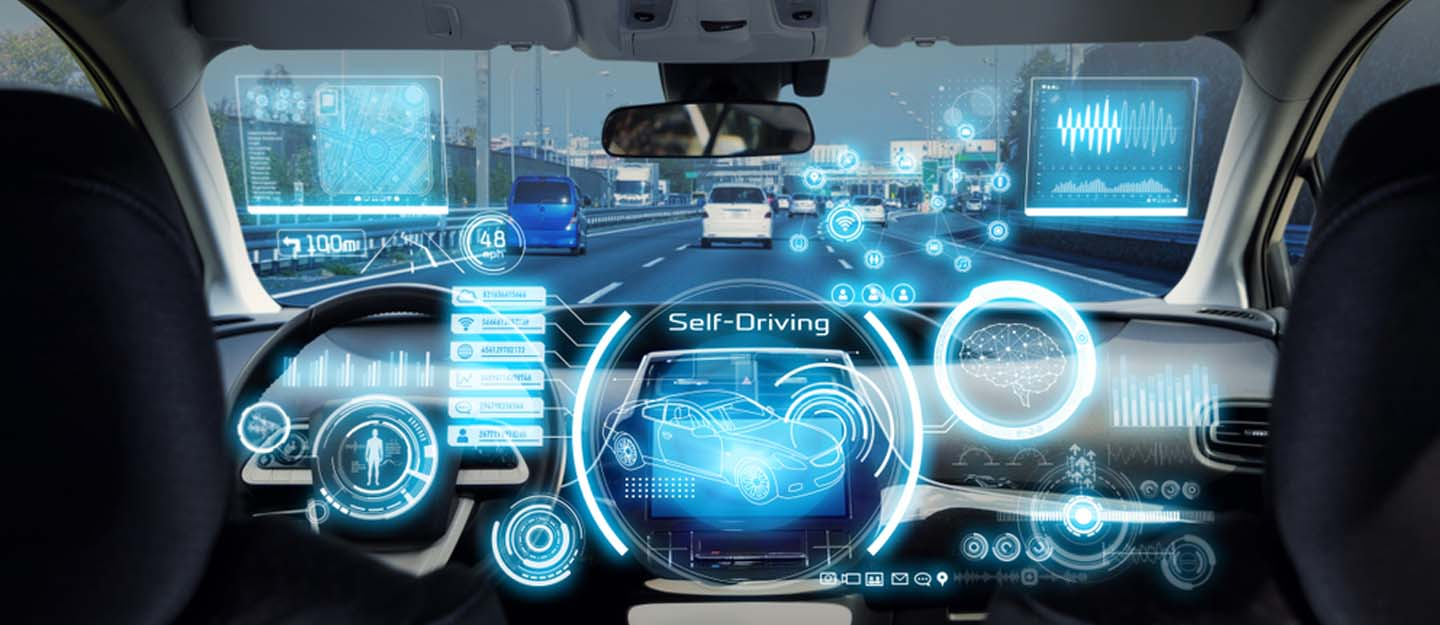

In [61]:
vo_data = {}
vo_data['output']="/Users/Nadav/Desktop/TAU/dataset" 
vo_data['images'] = "/Users/Nadav/Desktop/TAU/dataset/sequences"
vo_data['poses'] = "/Users/Nadav/Desktop/TAU/dataset/poses"
vo_data['sequence'] = 2 #run on sequance 2

In [62]:
N= 500 #number of frame, to run all the records change to 4658
project = ProjectQuestions(vo_data,N)
#project.run()

In [63]:
gt_trajectory, measured_trajectory=project.run()

2it [00:00,  4.29it/s]

frame: 0


12it [00:04,  2.44it/s]

frame: 10


22it [00:08,  2.49it/s]

frame: 20


32it [00:12,  2.41it/s]

frame: 30


42it [00:16,  2.50it/s]

frame: 40


52it [00:20,  2.28it/s]

frame: 50


62it [00:26,  1.62it/s]

frame: 60


72it [00:32,  1.67it/s]

frame: 70


82it [00:38,  1.48it/s]

frame: 80


92it [00:46,  1.30it/s]

frame: 90


102it [00:53,  1.48it/s]

frame: 100


112it [00:58,  1.87it/s]

frame: 110


122it [01:03,  1.78it/s]

frame: 120


132it [01:10,  1.46it/s]

frame: 130


142it [01:16,  1.52it/s]

frame: 140


152it [01:22,  1.62it/s]

frame: 150


162it [01:28,  1.70it/s]

frame: 160


172it [01:34,  1.73it/s]

frame: 170


182it [01:40,  1.56it/s]

frame: 180


192it [01:47,  1.61it/s]

frame: 190


202it [01:53,  1.67it/s]

frame: 200


212it [01:59,  1.89it/s]

frame: 210


222it [02:03,  2.01it/s]

frame: 220


232it [02:08,  1.88it/s]

frame: 230


242it [02:13,  2.15it/s]

frame: 240


252it [02:18,  2.11it/s]

frame: 250


262it [02:23,  1.44it/s]

frame: 260


272it [02:28,  2.01it/s]

frame: 270


282it [02:33,  1.86it/s]

frame: 280


292it [02:39,  1.74it/s]

frame: 290


302it [02:44,  1.96it/s]

frame: 300


312it [02:49,  1.98it/s]

frame: 310


322it [02:54,  1.97it/s]

frame: 320


332it [03:00,  1.62it/s]

frame: 330


342it [03:05,  1.89it/s]

frame: 340


352it [03:10,  1.92it/s]

frame: 350


362it [03:16,  1.81it/s]

frame: 360


372it [03:21,  1.75it/s]

frame: 370


382it [03:27,  1.86it/s]

frame: 380


392it [03:32,  1.66it/s]

frame: 390


402it [03:39,  1.53it/s]

frame: 400


412it [03:46,  1.00it/s]

frame: 410


422it [03:52,  1.64it/s]

frame: 420


432it [03:58,  1.72it/s]

frame: 430


442it [04:04,  1.80it/s]

frame: 440


452it [04:09,  1.96it/s]

frame: 450


462it [04:14,  2.01it/s]

frame: 460


472it [04:19,  1.93it/s]

frame: 470


482it [04:24,  1.94it/s]

frame: 480


492it [04:29,  1.92it/s]

frame: 490


501it [04:33,  1.83it/s]


In [64]:
import matplotlib.pyplot as plt

def plot_trajectory(GT_location, VO_location):
    """
    Plot the ground truth and VO trajectories.
    :param GT_location: Ground Truth trajectory
    :param VO_location: VO estimated trajectory
    """
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=[16, 12])

    # Plot the trajectories
    ax.plot(VO_location[:, 0], VO_location[:, 1], 'r', label="VO-Estimated Trajectory")
    ax.plot(GT_location[:, 0], GT_location[:, 1], '--b', label="Ground Truth Trajectory")

    # Set title and labels
    ax.set_title("Trajectory Plot")
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")

    # Set axis limits
    ax.set_xlim(-50, 750)
    ax.set_ylim(-100, 1000)

    # Enable grid
    ax.grid(True)

    # Add legend
    ax.legend(loc="upper right")

    # Display the plot
    plt.show()

# Example usage
# GT_location and VO_location should be numpy arrays with shape (n, 2)
# plot_trajectory(GT_location, VO_location)
  # Save the figure
    fig.savefig("trajectory", bbox_inches='tight')

    # Close the figure to free up memory
    plt.close(fig)

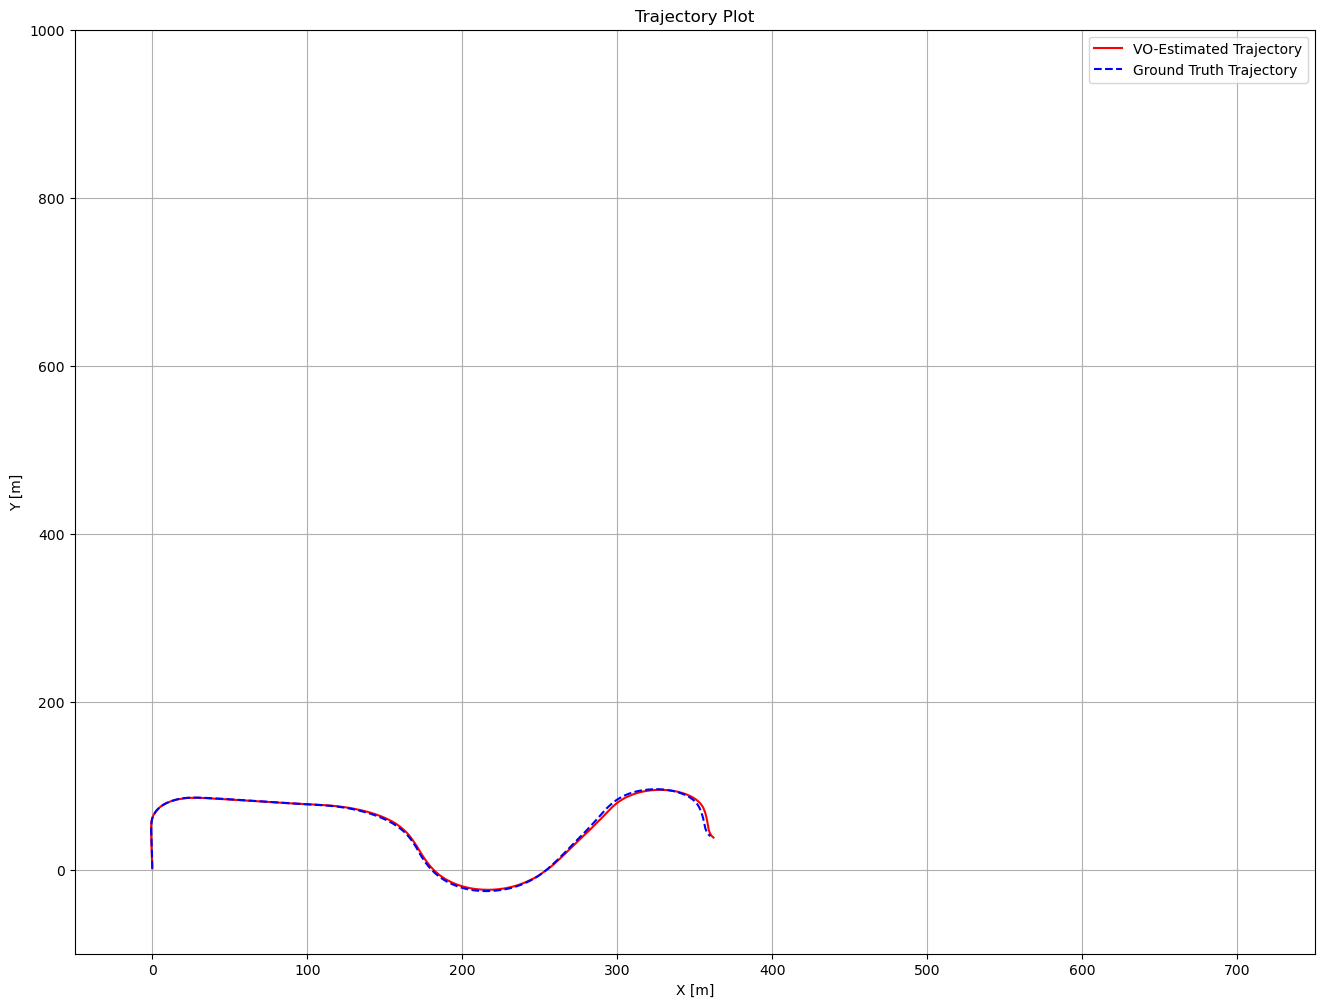

In [65]:
plot_trajectory(gt_trajectory, measured_trajectory)

# Save results to animation

In [67]:
import cv2
import os

def create_video_from_images(image_folder, output_video, fps=8):
    # Get list of images in the folder
    images = [img for img in os.listdir(image_folder) if img.endswith((".png", ".jpg", ".jpeg"))]
    images.sort()  # Sort images by name

    if not images:
        raise ValueError("No images found in the directory")

    # Read the first image to get dimensions
    first_image_path = os.path.join(image_folder, images[0])
    frame = cv2.imread(first_image_path)
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4
    video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    for image in images:
        image_path = os.path.join(image_folder, image)
        frame = cv2.imread(image_path)
        video.write(frame)

    video.release()
    print(f"Video saved as {output_video}")

# Parameters
image_folder = '/Users/Nadav/Desktop/TAU/dataset'  # Replace with your image folder path
output_video = 'output_video.mp4'  # Replace with your desired output video file name

create_video_from_images(image_folder, output_video)

Video saved as output_video.mp4
